In [1]:
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models
from models.utils import save_model

import pytorch_lightning as pl

from transforms.transform import base_transform, augmented_transform, IdentityTransform, simsiam_representation_transform

from models.encoders import get_resnet18_encoder, get_shufflenetv2_encoder, get_alexnet_encoder, SpectrumCNN

from models.lit_models import CNN_classifier, SimSiam

batch_size = 64

In [2]:
train_dataset_amp_phase = torchvision.datasets.ImageFolder('data/images_amp_phase/train', transform=base_transform)
train_dataloader = DataLoader(train_dataset_amp_phase, shuffle=True, batch_size=batch_size, num_workers=1)

In [3]:
train_dataset_spectrogram = torchvision.datasets.ImageFolder('data/images_amp_phase/train', transform=base_transform)
train_dataloader = DataLoader(train_dataset_spectrogram, shuffle=True, batch_size=batch_size, num_workers=1)

In [4]:
encoder = get_resnet18_encoder()
transform = simsiam_representation_transform
lit_model = SimSiam(encoder=encoder, transforms=transform)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:59: LightningDeprecationWarning: Setting `Trainer(flush_logs_every_n_steps=50)` is deprecated in v1.5 and will be removed in v1.7. Please configure flushing in the logger instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Finding best initial lr:  47%|████▋     | 47/100 [00:16<00:18,  2.83it/s]
LR finder stopped early after

4.786300923226385e-05


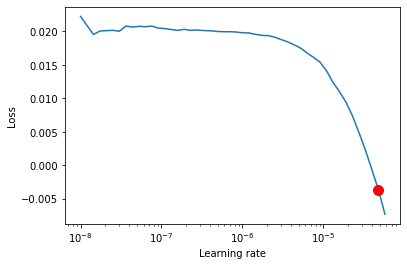

In [5]:
pretrainer = pl.Trainer(
    auto_lr_find=True,
    gpus=1, max_epochs=10,
    enable_checkpointing=True,
    log_every_n_steps=10,
    flush_logs_every_n_steps=50
)
# Run learning rate finder
lr_finder = pretrainer.tuner.lr_find(lit_model, train_dataloaders=train_dataloader)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()
print(lr_finder.suggestion())

In [6]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
lit_model.hparams.lr = new_lr

# # Fit model
pretrainer.fit(lit_model, train_dataloaders=train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | encoder   | Sequential       | 11.4 M
1 | predictor | Sequential       | 263 K 
2 | criterion | CosineSimilarity | 0     
-----------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.809    Total estimated model params size (MB)
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1:  15%|█▌        | 78/511 [00:30<02:47,  2.59it/s, loss=-0.97, v_num=10] 

/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
save_model(model=lit_model.encoder, save_path=input("Save model as:"),)

('amongus.pth', {})